In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Read the data

In [3]:
raw_data = []

with open('splice.data', 'r') as file:
    for line in file:
        raw_data.append(line.strip())

print("Number of samples:", len(raw_data))
print("Example line:", raw_data[0])

Number of samples: 3190
Example line: EI,    ATRINS-DONOR-521,               CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCCTTCGAGCCAGTCTG


## Extract Labels and Sequences

In [4]:
labels = []
sequences = []

for entry in raw_data:
    parts = entry.split(',')
    label = parts[0].strip()
    sequence = parts[2].strip()
    labels.append(label)
    sequences.append(sequence)

print("First label:", labels[0])
print("First sequence:", sequences[0])

First label: EI
First sequence: CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCCTTCGAGCCAGTCTG


## One-Hot Encode the Sequences

In [5]:
def one_hot_encode_sequence(seq):
    mapping = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]}  # Unknown nucleotides

    encoding = []
    for nucleotide in seq:
        encoding.extend(mapping.get(nucleotide, [0, 0, 0, 0]))  # If non-ACGT, use zeros
    return encoding

# Apply encoding to all sequences
feature_list = [one_hot_encode_sequence(seq) for seq in sequences]

# Check first encoded sequence
print("Features for first sequence (length):", len(feature_list[0]))
print(feature_list[0][:20])  # Show first 20 values

Features for first sequence (length): 240
[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


## convert the feature list into a pandas DataFrame and attach the labels

In [6]:
import pandas as pd

# Create DataFrame for features
X = pd.DataFrame(feature_list)

# Show shape and first few rows
print("Feature matrix shape:", X.shape)
X.head()

Feature matrix shape: (3190, 240)


,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Convert Labels to Numeric

In [7]:
label_mapping = {'EI': 1, 'IE': 2, 'N': 3}
y = [label_mapping[lbl] for lbl in labels]

# Add as new column
X['Class'] = y

# Check
X.head()


,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,Class
0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [8]:
X.to_csv('dna.csv', index=False)

## Train-Test Split and Scaling

In [9]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X_features = X.drop('Class', axis=1).values
y_labels = X['Class'].values

# Split into train/test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels,
    test_size=0.3,
    random_state=42,
    stratify=y_labels
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 2233
Testing samples: 957


### Scale the features

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Classical Baseline Model (SVM)

### Train Classical SVM

In [11]:
from sklearn.svm import SVC

# Classical SVM with RBF kernel
svm_classical = SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the model
svm_classical.fit(X_train_scaled, y_train)

SVC()

In [12]:
y_pred_classical = svm_classical.predict(X_test_scaled)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("🔵 Classical SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_classical))
print("Precision:", precision_score(y_test, y_pred_classical, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_classical, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_classical, average='weighted'))

🔵 Classical SVM Results:
Accuracy: 0.9582027168234065
Precision: 0.9584300135004284
Recall: 0.9582027168234065
F1 Score: 0.958277130047584


# Quantum Kernel

In [14]:
from azure.quantum import Workspace

workspace = Workspace(
    subscription_id="a12d5539-9bcb-4968-9110-32f91884619f",
    resource_group="quantum-rg",
    name="quantum-CSE720",
    location="East US"  # e.g., "eastus"
)

print("✅ Connected to Azure Quantum Workspace")


✅ Connected to Azure Quantum Workspace


In [23]:
from azure.quantum.qiskit import AzureQuantumProvider

provider = AzureQuantumProvider(workspace=workspace)

print("Available backends:")
for backend in provider.backends():
    print("-", backend.name())

Available backends:
- ionq.simulator
- ionq.qpu.aria-1
- ionq.qpu.aria-2
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1e


### PCA Dimensionality Reduction

In [15]:
from sklearn.decomposition import PCA

# Reduce to 10 components
pca = PCA(n_components=10)

# Fit PCA on training data and transform
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Reduced training shape:", X_train_pca.shape)
print("Reduced testing shape:", X_test_pca.shape)


Reduced training shape: (2233, 10)
Reduced testing shape: (957, 10)


### Define Quantum Feature Map

In [22]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from azure.quantum.qiskit import AzureQuantumProvider

### Reconnect to provider and select backend

In [24]:
provider = AzureQuantumProvider(workspace=workspace)

backend = provider.get_backend("ionq.simulator")
print("✅ Backend selected:", backend.name())

✅ Backend selected: ionq.simulator


### Define the quantum feature map

In [ ]:
feature_dim = X_train_pca.shape[1] 

feature_map = ZZFeatureMap(
    feature_dimension=feature_dim,
    reps=2,
    entanglement="full"
)

print("✅ Feature map created with", feature_dim, "features.")

✅ Feature map created with 10 features.


### Create the Fidelity Quantum Kernel

In [26]:
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    enforce_psd=True
)

print("✅ Fidelity quantum kernel created.")


✅ Fidelity quantum kernel created.


### Evaluate the kernel matrices

In [27]:
print("🔎 Computing training kernel matrix...")
kernel_matrix_train = quantum_kernel.evaluate(X_train_pca, X_train_pca)

print("🔎 Computing testing kernel matrix...")
kernel_matrix_test = quantum_kernel.evaluate(X_test_pca, X_train_pca)

print("✅ Kernel matrices computed.")


🔎 Computing training kernel matrix...


: 

In [16]:
print("Training shape:", X_train_pca.shape)
print("Testing shape:", X_test_pca.shape)

Training shape: (2233, 10)
Testing shape: (957, 10)


In [17]:
# Select first 50 training samples and first 20 testing samples
X_train_small = X_train_pca[:50]
y_train_small = y_train[:50]

X_test_small = X_test_pca[:20]
y_test_small = y_test[:20]

print("Training shape:", X_train_small.shape)
print("Testing shape:", X_test_small.shape)


Training shape: (50, 10)
Testing shape: (20, 10)


In [19]:
from qiskit.circuit.library import ZZFeatureMap

feature_dim = X_train_small.shape[1]

feature_map = ZZFeatureMap(
    feature_dimension=feature_dim,
    reps=2,
    entanglement="full"
)

print("✅ Feature map ready for 10 features.")


✅ Feature map ready for 10 features.


In [20]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

def build_fidelity_circuit(x1, x2, feature_map):
    """
    Builds a state overlap (fidelity) circuit between two datapoints x1 and x2.
    """
    num_qubits = len(x1)
    qc = QuantumCircuit(num_qubits)
    
    # First state preparation
    params1 = ParameterVector('x1', num_qubits)
    fm1 = feature_map.assign_parameters(params1)
    qc.compose(fm1, inplace=True)
    
    # Invert second state preparation
    params2 = ParameterVector('x2', num_qubits)
    fm2 = feature_map.assign_parameters(params2)
    fm2 = fm2.inverse()
    qc.compose(fm2, inplace=True)
    
    # Measurement in computational basis
    qc.measure_all()
    
    qc = qc.bind_parameters({**{params1[i]: x1[i] for i in range(num_qubits)},
                             **{params2[i]: x2[i] for i in range(num_qubits)}})
    return qc


In [26]:
def build_fidelity_circuit(x1, x2, feature_map):
    num_qubits = len(x1)
    qc = QuantumCircuit(num_qubits)
    
    # First state preparation
    params1 = ParameterVector('x1', num_qubits)
    fm1 = feature_map.assign_parameters(params1)
    qc.compose(fm1, inplace=True)
    
    # Invert second state preparation
    params2 = ParameterVector('x2', num_qubits)
    fm2 = feature_map.assign_parameters(params2)
    fm2 = fm2.inverse()
    qc.compose(fm2, inplace=True)
    
    # Measurement in computational basis
    qc.measure_all()

    qc = qc.assign_parameters({**{params1[i]: x1[i] for i in range(num_qubits)},
                               **{params2[i]: x2[i] for i in range(num_qubits)}})
    return qc


In [27]:
train_circuits = []
for i in range(len(X_train_small)):
    for j in range(len(X_train_small)):
        qc = build_fidelity_circuit(X_train_small[i], X_train_small[j], feature_map)
        train_circuits.append(qc)

print("✅ Training circuits prepared:", len(train_circuits))


✅ Training circuits prepared: 2500


In [29]:
import time

job_ids = []

for idx, qc in enumerate(train_circuits):
    print(f"Submitting circuit {idx+1} of {len(train_circuits)}...")

    try:
        job = backend.run(qc, shots=1024)
        job_id = job.id()
        job_ids.append(job_id)
        print(f"✅ Submitted. Job ID: {job_id}")
    except Exception as e:
        print(f"❌ Failed to submit circuit {idx+1}: {e}")
        job_ids.append(None)

    # OPTIONAL: To avoid overwhelming the API, add a short delay
    time.sleep(0.5)  # 0.5 second pause between submissions

print(f"✅ All submissions done. {len(job_ids)} jobs submitted.")

# Save the job IDs to a file for tracking later
import json
with open("training_kernel_job_ids.json", "w") as f:
    json.dump(job_ids, f)

print("✅ Job IDs saved to training_kernel_job_ids.json.")


Submitting circuit 1 of 2500...
✅ Submitted. Job ID: f3af5492-2676-11f0-8ebb-00155d5d2fae
Submitting circuit 2 of 2500...
✅ Submitted. Job ID: fb9ee096-2676-11f0-8ebb-00155d5d2fae
Submitting circuit 3 of 2500...
✅ Submitted. Job ID: ff30fa0a-2676-11f0-8ebb-00155d5d2fae
Submitting circuit 4 of 2500...
✅ Submitted. Job ID: 045cc428-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 5 of 2500...
✅ Submitted. Job ID: 1d4a7200-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 6 of 2500...
✅ Submitted. Job ID: 26b366d0-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 7 of 2500...
✅ Submitted. Job ID: 2b6d0fa0-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 8 of 2500...
✅ Submitted. Job ID: 2f0ee7fa-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 9 of 2500...
✅ Submitted. Job ID: 363c2754-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 10 of 2500...
✅ Submitted. Job ID: 3a058114-2677-11f0-8ebb-00155d5d2fae
Submitting circuit 11 of 2500...
✅ Submitted. Job ID: 3dcb94b4-2677-11f0-8ebb-00155d5d2fae
Submitti

_DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	_TokenFileCredential: Token file location not set.
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	VisualStudioCodeCredential: Failed to get Azure user details from Visual Studio Code. Currently, the VisualStudioCodeCredential only works with the Azure Account extension version 0.9.11 and earlier. A long-term fix is in progress, see https://github.com/Azure/azure-sdk-for-python/issues/25713
	AzureCliCredential: Failed to invoke the Azure CLI
	AzurePowerShellCredential: PowerShell is not installed
	InteractiveBrowserCredential: Timed out after waiting 300 seconds for the user to authenticate


❌ Failed to submit circuit 247: _DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	_TokenFileCredential: Token file location not set.
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	VisualStudioCodeCredential: Failed to get Azure user details from Visual Studio Code. Currently, the VisualStudioCodeCredential only works with the Azure Account extension version 0.9.11 and earlier. A long-term fix is in progress, see https://github.com/Azure/azure-sdk-for-python/issues/25713
	AzureCliCredential: Failed to invoke the Azure CLI
	AzurePowerShellCredential: PowerShell is not installed
	InteractiveBrowserCredential: Timed out after waiting 300 seconds for the user to authenticate
Submitting circuit 248 of 2500...
✅ Submitted. Job ID: 6f82d44e-267d-11f0-8ebb-0015

In [31]:
import json
from azure.quantum.qiskit import AzureQuantumProvider

# Load job IDs
with open("training_kernel_job_ids.json", "r") as f:
    job_ids = json.load(f)

print(f"Loaded {len(job_ids)} job IDs.")

# Initialize provider
provider = AzureQuantumProvider(
    subscription_id="a12d5539-9bcb-4968-9110-32f91884619f",
    resource_group="quantum-rg",
    name="quantum-CSE720",
    location="East US"
)

# Pick your backend (should be the same as what you used to submit)
backend = provider.get_backend("ionq.simulator")

# Check status of each job
completed_jobs = []
pending_jobs = []

for job_id in job_ids:
    if not job_id or job_id.strip() == "":
        print("⚠ Skipping empty job ID.")
        continue

    job = backend.retrieve_job(job_id)
    status = job.status()
    print(f"Job {job_id} status: {status}")

    if status == "DONE":
        completed_jobs.append(job_id)
    else:
        pending_jobs.append(job_id)

print(f"\n✅ Completed jobs: {len(completed_jobs)}")
print(f"⏳ Pending jobs: {len(pending_jobs)}")


Loaded 2500 job IDs.


/tmp/ipykernel_23291/2666817554.py:11: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "subscription_id", "resource_group", "name", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider(


Job f3af5492-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job fb9ee096-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job ff30fa0a-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 045cc428-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 1d4a7200-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 26b366d0-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 2b6d0fa0-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 2f0ee7fa-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 363c2754-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 3a058114-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 3dcb94b4-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 453bd97a-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 4aa23602-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 4e0c1650-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 51651efa-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 558faf9a-2677-11f0-8ebb-00155d5d2fae

In [ ]:
import json
from azure.quantum.qiskit import AzureQuantumProvider

# Load job IDs
with open("training_kernel_job_ids.json", "r") as f:
    job_ids = json.load(f)

print(f"Loaded {len(job_ids)} job IDs.")

# Initialize provider
provider = AzureQuantumProvider(
    subscription_id="a12d5539-9bcb-4968-9110-32f91884619f",
    resource_group="quantum-rg",
    name="quantum-CSE720",
    location="East US"
)

# Pick your backend 
backend = provider.get_backend("ionq.simulator")

# Check status of each job
completed_jobs = []
pending_jobs = []

for job_id in job_ids:
    if not job_id or job_id.strip() == "":
        print("⚠ Skipping empty job ID.")
        continue

    job = backend.retrieve_job(job_id)
    status = job.status()
    print(f"Job {job_id} status: {status}")

    if status == "DONE":
        completed_jobs.append(job_id)
    else:
        pending_jobs.append(job_id)

print(f"\n✅ Completed jobs: {len(completed_jobs)}")
print(f"⏳ Pending jobs: {len(pending_jobs)}")


Loaded 2500 job IDs.


/tmp/ipykernel_23291/2666817554.py:11: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "subscription_id", "resource_group", "name", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider(


Job f3af5492-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job fb9ee096-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job ff30fa0a-2676-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 045cc428-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 1d4a7200-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 26b366d0-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 2b6d0fa0-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 2f0ee7fa-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 363c2754-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 3a058114-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 3dcb94b4-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 453bd97a-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 4aa23602-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 4e0c1650-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 51651efa-2677-11f0-8ebb-00155d5d2fae status: JobStatus.DONE
Job 558faf9a-2677-11f0-8ebb-00155d5d2fae

In [ ]:
import json
import numpy as np
from azure.quantum.qiskit import AzureQuantumProvider

# Load job IDs
with open("training_kernel_job_ids.json", "r") as f:
    job_ids = json.load(f)

print(f"Loaded {len(job_ids)} job IDs.")

# Initialize provider
provider = AzureQuantumProvider(
    subscription_id="a12d5539-9bcb-4968-9110-32f91884619f",
    resource_group="quantum-rg",
    name="quantum-CSE720",
    location="East US"
)

backend = provider.get_backend("ionq.simulator")

# Kernel matrix initialization
num_samples = int(np.sqrt(len(job_ids)))   # Because circuits were for all pairs (i,j)
K = np.zeros((num_samples, num_samples))

print("Retrieving job results and building kernel matrix...")

job_index = 0
for i in range(num_samples):
    for j in range(num_samples):

        if job_index >= len(job_ids):
            break

        job_id = job_ids[job_index]
        job_index += 1

        if not job_id or job_id.strip() == "":
            print(f"⚠ Skipping empty job ID at index {job_index}.")
            continue

        job = backend.retrieve_job(job_id)
        status = job.status()

        # Updated status check using .name (always safe)
        if status.name not in ["DONE", "SUCCEEDED"]:
            print(f"⏳ Job {job_id} not complete yet. Status: {status.name}. Skipping.")
            continue

        result = job.result()
        counts = result.get_counts()

        num_qubits = 10  # Manually set to match PCA dimensionality
        all_zero = '0' * num_qubits
        zero_counts = counts.get(all_zero, 0)
        total_counts = sum(counts.values())

        fidelity = zero_counts / total_counts if total_counts > 0 else 0
        K[i, j] = fidelity

        print(f"✅ Job {job_id}: K[{i},{j}] = {fidelity:.4f}")

print("\n✅ Quantum kernel matrix construction complete.")
print("Kernel matrix shape:", K.shape)

# Save the matrix for future use
np.save("quantum_kernel_matrix.npy", K)


Loaded 2500 job IDs.


/tmp/ipykernel_23291/2183864226.py:12: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "subscription_id", "resource_group", "name", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider(


Retrieving job results and building kernel matrix...
✅ Job f3af5492-2676-11f0-8ebb-00155d5d2fae: K[0,0] = 1.0000
✅ Job fb9ee096-2676-11f0-8ebb-00155d5d2fae: K[0,1] = 0.0000
✅ Job ff30fa0a-2676-11f0-8ebb-00155d5d2fae: K[0,2] = 0.0017
✅ Job 045cc428-2677-11f0-8ebb-00155d5d2fae: K[0,3] = 0.0000
✅ Job 1d4a7200-2677-11f0-8ebb-00155d5d2fae: K[0,4] = 0.0017
✅ Job 26b366d0-2677-11f0-8ebb-00155d5d2fae: K[0,5] = 0.0016
✅ Job 2b6d0fa0-2677-11f0-8ebb-00155d5d2fae: K[0,6] = 0.0050
✅ Job 2f0ee7fa-2677-11f0-8ebb-00155d5d2fae: K[0,7] = 0.0017
✅ Job 363c2754-2677-11f0-8ebb-00155d5d2fae: K[0,8] = 0.0000
✅ Job 3a058114-2677-11f0-8ebb-00155d5d2fae: K[0,9] = 0.0017
✅ Job 3dcb94b4-2677-11f0-8ebb-00155d5d2fae: K[0,10] = 0.0067
✅ Job 453bd97a-2677-11f0-8ebb-00155d5d2fae: K[0,11] = 0.0000
✅ Job 4aa23602-2677-11f0-8ebb-00155d5d2fae: K[0,12] = 0.0000
✅ Job 4e0c1650-2677-11f0-8ebb-00155d5d2fae: K[0,13] = 0.0000
✅ Job 51651efa-2677-11f0-8ebb-00155d5d2fae: K[0,14] = 0.0017
✅ Job 558faf9a-2677-11f0-8ebb-00155d5d2fae

✅ Quantum kernel matrix loaded. Shape: (50, 50)
✅ Quantum SVM trained.
🔎 Quantum SVM Training Accuracy: 1.0000

Classification Report (Training Data):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        26

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



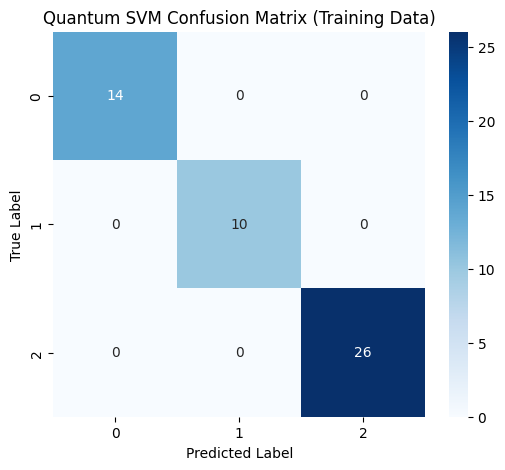

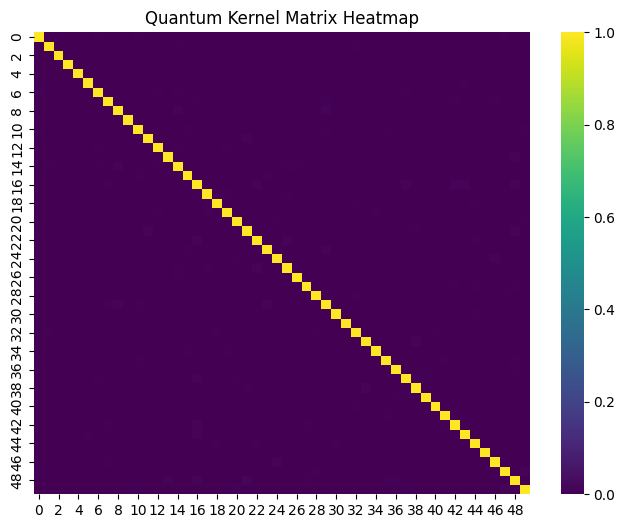

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the quantum kernel matrix
quantum_kernel = np.load("quantum_kernel_matrix.npy")
print("✅ Quantum kernel matrix loaded. Shape:", quantum_kernel.shape)

# Select the labels that correspond to the kernel matrix

# Only the first 50 samples were used to build the quantum kernel
y_train_small = y_train[:50]
# y_test_small = y_test[:50]  # Not used now because no test kernel available

# Train the SVM using the quantum kernel
clf = SVC(kernel='precomputed')

# Training kernel (quantum similarities among training points)
K_train = quantum_kernel[:len(y_train_small), :len(y_train_small)]

# Train the classifier
clf.fit(K_train, y_train_small)
print("✅ Quantum SVM trained.")

# Predict using the training kernel itself
y_pred_quantum = clf.predict(K_train)

# Evaluate the Quantum SVM (Training Accuracy)
accuracy = accuracy_score(y_train_small, y_pred_quantum)
print(f"🔎 Quantum SVM Training Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report (Training Data):")
print(classification_report(y_train_small, y_pred_quantum))

# Confusion matrix
cm = confusion_matrix(y_train_small, y_pred_quantum)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Quantum SVM Confusion Matrix (Training Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Quantum Kernel Matrix Heatmap (optional visualization)
plt.figure(figsize=(8, 6))
sns.heatmap(quantum_kernel, cmap='viridis')
plt.title("Quantum Kernel Matrix Heatmap")
plt.show()
